In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from scipy import signal
from sklearn.cross_decomposition import CCA
from scipy.signal import kaiserord, lfilter, firwin, freqz, butter, filtfilt, convolve
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

## Load Dataset

In [2]:
# theta     -> 4-8 Hz
# alpha     -> 8-12 Hz
# low beta  -> 12-16 Hz
# high beta -> 16-25 Hz
# gamma     -> 25-45 Hz
# our freqs: 15 (betaL), 12 (alpha/betaL), 8.57 (alpha), 5.45 (theta)

dataset_name = "recordings/psychopy_sultan_recording_" # 0 to 3
num_targets = 4
targets = [None] * num_targets
channels = ['O1/theta', 'O1/alpha', 'O1/betaL', 'O1/betaH', 'O1/gamma', 'O2/theta', 'O2/alpha', 'O2/betaL', 'O2/betaH', 'O2/gamma'] # data channels
for i in range(num_targets):
    targets[i] = pd.read_csv(dataset_name+str(i)+'.csv')
    targets[i]['Unnamed: 0'] = [i % 8 for i in range(len(targets[i].index))]
    targets[i].rename(columns = {'Unnamed: 0': 'Counter'}, inplace=True)
targets[0].head

<bound method NDFrame.head of      Counter  O1/theta  O1/alpha  O1/betaL  O1/betaH  O1/gamma  O2/theta  \
0          0     0.598     0.750     0.959     0.850     0.640     0.630   
1          1     0.725     0.918     1.052     0.883     0.582     0.568   
2          2     0.809     1.082     1.081     0.868     0.529     0.494   
3          3     0.808     1.178     1.037     0.801     0.489     0.415   
4          4     0.721     1.161     0.937     0.695     0.466     0.354   
..       ...       ...       ...       ...       ...       ...       ...   
595        3     0.299     0.428     0.171     0.174     0.184     0.091   
596        4     0.357     0.420     0.189     0.184     0.190     0.090   
597        5     0.406     0.452     0.198     0.197     0.196     0.095   
598        6     0.433     0.521     0.195     0.206     0.205     0.106   
599        7     0.427     0.611     0.186     0.215     0.217     0.124   

     O2/alpha  O2/betaL  O2/betaH  O2/gamma          TIME

In [3]:
def cut_uneven_datasets(df_list):
    # use this function if the datasets are of uneven length - chop to minimum df size
    cutoff_list = [len(df_list[i].index) for i in range(num_targets)]
    cutoff = min(cutoff_list)
    for i in range(len(cutoff_list)):
        keep_indicies = set(range(df_list[i].shape[0])) - set(range(cutoff, df_list[i].shape[0]))
        df_list[i] = df_list[i].take(list(keep_indicies))
        # make sure each df same length
        print('new length of dataset {} = {}'.format(i+1, len(df_list[i].index)))
    return df_list
        
# check size - make sure each target is the same length
for i in range(num_targets):
    print('length target {} = {}'.format(i, len(targets[i].index)))

# fix length
# targets = cut_uneven_datasets(targets)

length target 0 = 600
length target 1 = 600
length target 2 = 600
length target 3 = 600


In [4]:
# copy unfiltered data
original_data = [None] * num_targets
for i in range(num_targets):
    original_data[i] = pd.read_csv(dataset_name+str(i)+'.csv')
    original_data[i]['Unnamed: 0'] = [i % 120 for i in range(len(original_data[i].index))]
    original_data[i].rename(columns = {'Unnamed: 0': 'Counter'}, inplace=True)

In [5]:
# plot power bands over time
def plot_bands(targets, start=0, end=600):
    names = ['theta', 'alpha', 'betaL', 'betaH', 'gamma']
    for i in range(num_targets):
        fig1, ax1 = plt.subplots(figsize=(10, 5))
        fig2, ax2 = plt.subplots(figsize=(10, 5))
        for channel in channels:
            if 'O1' in channel:
                a = ax1
                ch = 'O1'
            elif 'O2' in channel:
                a = ax2
                ch = 'O2'
            targets[i][channel][start:end].plot(y=channel, grid=True, ax=a, title='Target {}, {} Power Bands Over Time'.format(i, ch))
            a.legend(names)

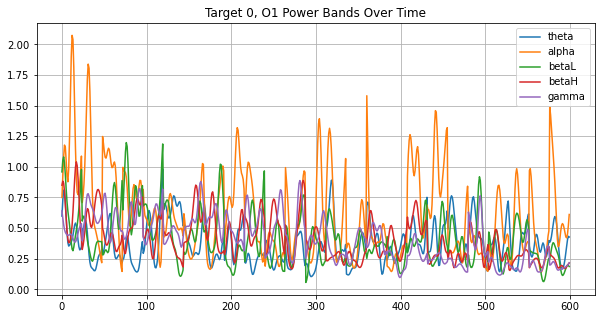

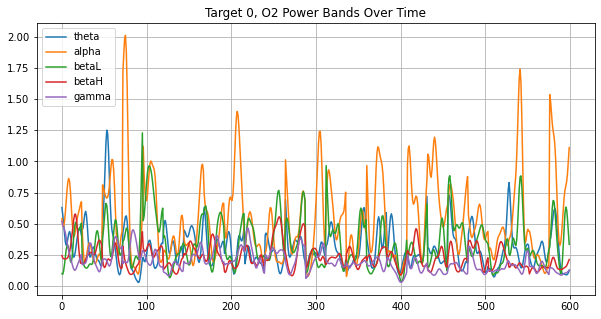

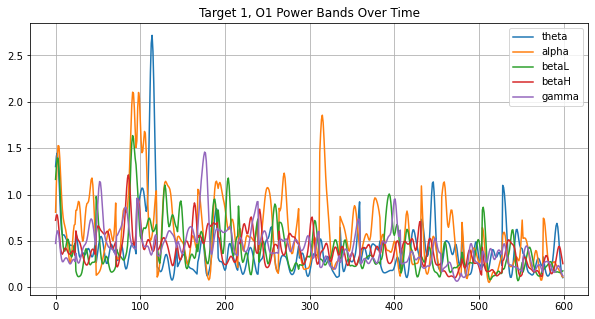

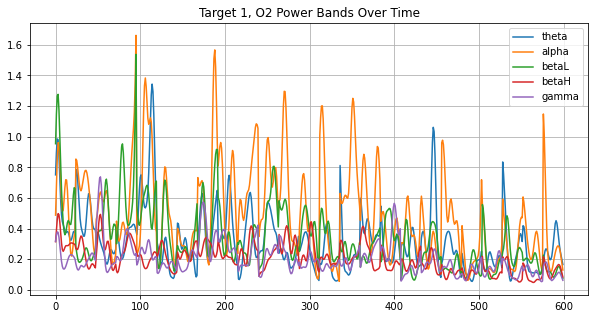

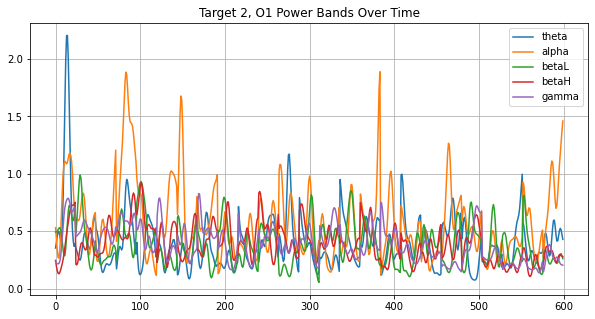

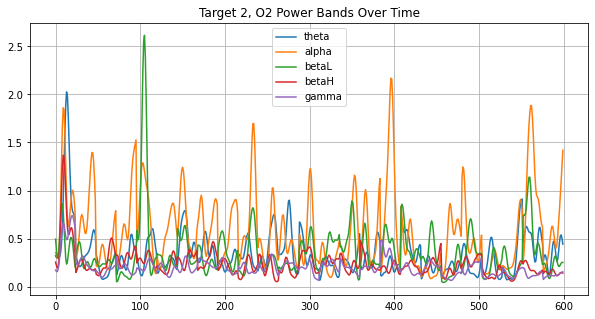

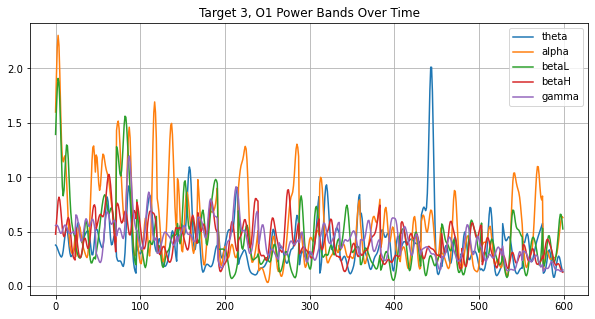

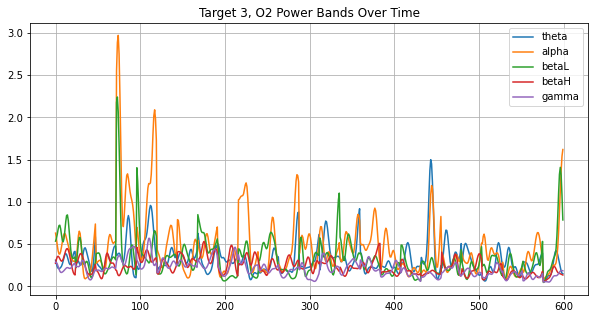

In [6]:
plot_bands(targets)

In [7]:
# find channel with highest average value in each 1s period (or 2s, 3s?)
def average_power_features(targets, num_seconds=1):
    o1_channels = ['O1/theta', 'O1/alpha', 'O1/betaL', 'O1/betaH', 'O1/gamma'] 
    o2_channels = ['O2/theta', 'O2/alpha', 'O2/betaL', 'O2/betaH', 'O2/gamma']
    # targets - list of df's
    # sampling freq of 8 per second
    num_chunks = len(targets[0].index) // (8 * num_seconds)
    features = np.zeros([num_chunks * num_targets, 11])
    chunk = 0
    stop_row = len(targets[0].index)
    for i in range(num_targets):
        row = 0
        while True:
            if row >= stop_row or stop_row - row < 8 * num_seconds:
                break
            o1_data = np.asarray(targets[i][o1_channels][row:row+8*num_seconds])
            o2_data = np.asarray(targets[i][o2_channels][row:row+8*num_seconds])
            # which channel has highest average value?
            # do for o1 and o2
            # average
            o1_avgs = o1_data.mean(axis=0)
            o2_avgs = o2_data.mean(axis=0)
            
            # print(o1_avgs)
            # print(o2_avgs)
            
            max1_o1 = np.argmax(o1_avgs)
            o1_avgs[max1_o1] = 0
            max2_o1 = np.argmax(o1_avgs)
            max1_o2 = np.argmax(o2_avgs)
            o2_avgs[max1_o2] = 0
            max2_o2 = np.argmax(o2_avgs)
            o1_sel = [o1_channels[max1_o1], o1_channels[max2_o1]]
            o2_sel = [o2_channels[max1_o2], o2_channels[max2_o2]]
            
            # print('o1', o1_avgs, '\n')
            # print('o2', o2_avgs, '\n')
            
            # print('target {} row {} prediction'.format(i, row))
            # print('o1 -> {}'.format(o1_sel))
            # print('o2 -> {}\n'.format(o2_sel))
            
            features_row = np.hstack((o1_avgs, o2_avgs))
            features_row = np.append(features_row, i)
            features[chunk] = features_row
        
            
            chunk += 1
            row += 8 * num_seconds
            
    return features
            

In [8]:
def get_knn_accuracy(num_seconds):
    features = average_power_features(targets, num_seconds=num_seconds)
    feat = features[:, :-1]
    labels = features[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(feat, labels, test_size=0.20)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    print('KNN Accuracy for {} seconds: '.format(num_seconds), metrics.accuracy_score(y_test, pred))
    print('Predicted actions:')
    print([int(i) for i in pred])
    print('Correct actions:')
    print([int(i) for i in y_test])
    print('\n')

In [9]:
get_knn_accuracy(num_seconds=1)
get_knn_accuracy(num_seconds=2)
get_knn_accuracy(num_seconds=3)

KNN Accuracy for 1 seconds:  0.26666666666666666
Predicted actions:
[1, 0, 0, 0, 3, 0, 1, 2, 2, 0, 2, 1, 2, 3, 2, 0, 2, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 1, 3, 1, 1, 0, 2, 0, 2, 2, 2, 3, 1, 0, 3, 1, 0, 2, 0, 0, 0]
Correct actions:
[2, 3, 2, 3, 0, 1, 2, 2, 1, 3, 1, 2, 2, 0, 3, 0, 1, 3, 3, 1, 1, 0, 2, 1, 2, 3, 1, 1, 3, 1, 3, 2, 0, 2, 0, 3, 2, 2, 3, 3, 3, 2, 0, 1, 1, 0, 2, 3, 2, 3, 3, 2, 1, 1, 1, 3, 1, 0, 2, 0]


KNN Accuracy for 2 seconds:  0.13333333333333333
Predicted actions:
[2, 1, 2, 3, 1, 0, 2, 0, 1, 0, 3, 1, 2, 3, 0, 2, 0, 2, 2, 0, 1, 0, 1, 0, 2, 0, 0, 1, 0, 1]
Correct actions:
[3, 1, 0, 1, 0, 0, 3, 3, 2, 3, 3, 2, 3, 0, 3, 1, 1, 0, 0, 1, 2, 2, 0, 2, 3, 3, 3, 3, 0, 3]


KNN Accuracy for 3 seconds:  0.2
Predicted actions:
[3, 1, 2, 0, 1, 0, 0, 0, 1, 1, 0, 0, 2, 3, 3, 3, 2, 0, 0, 1]
Correct actions:
[2, 3, 3, 3, 2, 0, 2, 0, 1, 2, 3, 1, 3, 1, 1, 3, 1, 1, 1, 0]


